# ATE vs ATET vs ATEU
Julian Hsu
30-july-2023


The purpose of this script is to demonstrate the difference between the Average Treatment Effect (ATE), Average Treatment Effect on the Treated (ATET), and Average Treatment Effect on the Untreated (ATEU). 

We will 

In [73]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict

import stnomics as st


## DGP Functions

In [64]:
def dgp(N=1000, at_mean=1):
    ## Initialize data frame of covariates
    data=pd.DataFrame(
        data={'x0':np.random.uniform(0,1,N)
             ,'x1':np.random.uniform(0,1,N)})
    x_list = [d for d in data.columns if 'x' in d]
        
    ## Determine the baseline outcome
    y0 = np.dot(data[x_list]
                              ,np.random.uniform(1,3,len(x_list)) )
    y0 += np.random.normal(0,0.25, N)
    
    ## Determine the impact which is correlated with the baseline outcome
    at = np.random.normal(at_mean,1, N)
    
    ## Determine treatment indicator
    ## based on the baseline outcome and impact and noise
    data['w'] = (np.exp(y0 + at) / (1+np.exp(y0+at)) + np.random.uniform(-1,1,N) > 1 ).astype(float)

    ## Calculate observed outcome
    y_obs = np.dot(data[x_list]
                              ,np.random.uniform(-1,1,len(x_list)) )\
            + np.random.normal(0,0.25,N)
    y_obs += data['w']*at
    data['y'] = y_obs
    data['at'] = at
    data['y0'] = y0
    
    return data
    

## Simulate different iterations to show that OLS estimates the ATET


In [93]:
atu_list=[]
att_list=[]
ate_list=[]
ols_est = []
sim_times = 200
for s in range(sim_times):
    df= dgp()
    X = sm.add_constant(df[['x0','x1','w']])
    ols_fit = sm.OLS( df['y'], X).fit()
    ols_estimate = ols_fit.params['w']
    true_atu = df.loc[df['w']==0]['at'].mean()
    true_att = df.loc[df['w']==1]['at'].mean()
    true_ate = df['at'].mean()
    # df.groupby('w')['at'].describe()
    atu_list.append(true_atu)
    att_list.append(true_att)
    ate_list.append(true_ate)
    ols_est.append(ols_estimate)

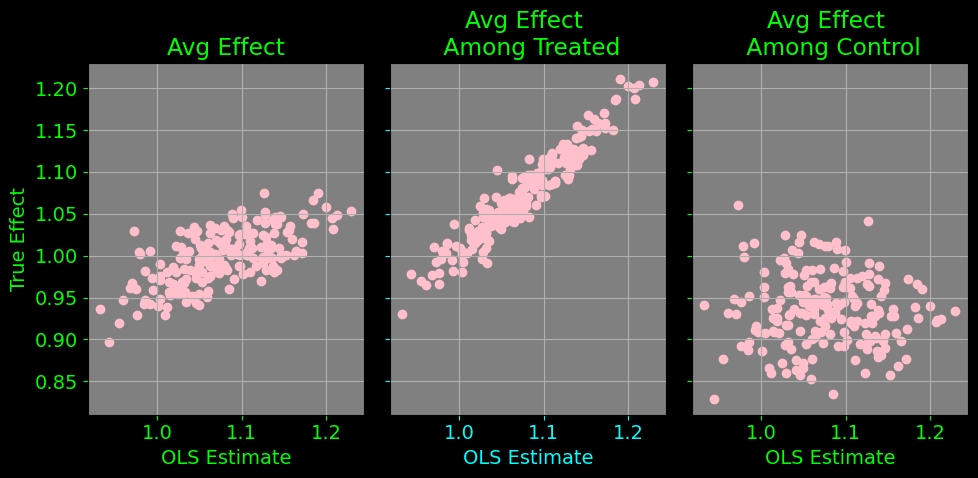

In [119]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(10,5)
                   ,sharex=True, sharey=True)
ax[0].scatter(ols_est, ate_list, color='pink')
ax[1].scatter(ols_est, att_list, color='pink')
ax[2].scatter(ols_est, atu_list, color='pink')
ax[0].set_ylabel('True Effect')
# ax[1].set_ylabel('Avg Effect for Treated Units')
# ax[2].set_ylabel('Avg Effect for Control Units')
ax[0].set_title('Avg Effect', color='lime')
ax[1].set_title('Avg Effect \n Among Treated', color='lime')
ax[2].set_title('Avg Effect \n Among Control', color='lime')
for r in [0,1,2]:
    ax[r].set_xlabel('OLS Estimate')

    if r==1:
        ax[r].grid()
        ax[r].xaxis.label.set_color('cyan')
        ax[r].yaxis.label.set_color('cyan')
        ax[r].tick_params(axis='x', colors='cyan')
        ax[r].tick_params(axis='y', colors='cyan')

        ax[r].set_facecolor('grey')
    else:
        ax[r].grid()
        ax[r].xaxis.label.set_color('lime')
        ax[r].yaxis.label.set_color('lime')
        ax[r].tick_params(axis='x', colors='lime')
        ax[r].tick_params(axis='y', colors='lime')

        ax[r].set_facecolor('grey')
    
fig.tight_layout()
fig.set_facecolor('black')
plt.show()

    